In [23]:
import catboost
from catboost import Pool, FeaturesData, CatBoostClassifier, CatBoost
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import sys

sys.path.insert(
    1, os.path.join(sys.path[0], "..")
)  # hack to import my own metrics file
import metrics

# Reading the data

In [2]:
data_filepath = r"/Users/jamesmoro/Documents/Python/playlist-recommender/playlist-creator/data/playlist_df.pkl"

In [3]:
raw_df = pd.read_pickle(data_filepath)

In [4]:
df = raw_df.copy()

In [5]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist_names,track_names,playlist_name
0,0.506,0.805,1,-4.119,1,0.0469,0.00711,0.00193,0.0856,0.383,...,audio_features,46lFttIf5hnUZMGvjK0Wxo,spotify:track:46lFttIf5hnUZMGvjK0Wxo,https://api.spotify.com/v1/tracks/46lFttIf5hnU...,https://api.spotify.com/v1/audio-analysis/46lF...,227074,4,Galantis,Runaway (U & I),briz party songz
1,0.490,0.811,1,-2.524,0,0.0440,0.08960,0.00000,0.0898,0.547,...,audio_features,5BIgbz2Dy7X2I0bnkKH9Mb,spotify:track:5BIgbz2Dy7X2I0bnkKH9Mb,https://api.spotify.com/v1/tracks/5BIgbz2Dy7X2...,https://api.spotify.com/v1/audio-analysis/5BIg...,200992,4,Tim Berg,Seek Bromance (Avicii Vocal Edit),briz party songz
2,0.527,0.835,6,-5.298,1,0.0433,0.01660,0.00000,0.2490,0.654,...,audio_features,0ct6r3EGTcMLPtrXHDvVjc,spotify:track:0ct6r3EGTcMLPtrXHDvVjc,https://api.spotify.com/v1/tracks/0ct6r3EGTcML...,https://api.spotify.com/v1/audio-analysis/0ct6...,176658,4,Avicii,The Nights,briz party songz
3,0.633,0.818,1,-5.437,1,0.0376,0.01140,0.00000,0.2590,0.337,...,audio_features,5r3aYGutXgsxSqB6W3RrzJ,spotify:track:5r3aYGutXgsxSqB6W3RrzJ,https://api.spotify.com/v1/tracks/5r3aYGutXgsx...,https://api.spotify.com/v1/audio-analysis/5r3a...,193481,4,The Magician,Sunlight (feat. Years and Years) - Radio Edit,briz party songz
4,0.662,0.858,2,-4.844,1,0.0428,0.00163,0.00000,0.0456,0.295,...,audio_features,6Pgkp4qUoTmJIPn7ReaGxL,spotify:track:6Pgkp4qUoTmJIPn7ReaGxL,https://api.spotify.com/v1/tracks/6Pgkp4qUoTmJ...,https://api.spotify.com/v1/audio-analysis/6Pgk...,181673,4,Avicii,Without You (feat. Sandro Cavazza),briz party songz


# Preparing the data

## Column Removal

In [6]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'artist_names', 'track_names', 'playlist_name'],
      dtype='object')

In [7]:
useless_cols = ["type", "id", "uri", "track_href", "analysis_url"]

In [8]:
df = df.drop(useless_cols, axis=1)

In [9]:
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_names,track_names,playlist_name
0,0.506,0.805,1,-4.119,1,0.0469,0.00711,0.00193,0.0856,0.383,126.008,227074,4,Galantis,Runaway (U & I),briz party songz
1,0.490,0.811,1,-2.524,0,0.0440,0.08960,0.00000,0.0898,0.547,125.965,200992,4,Tim Berg,Seek Bromance (Avicii Vocal Edit),briz party songz
2,0.527,0.835,6,-5.298,1,0.0433,0.01660,0.00000,0.2490,0.654,125.983,176658,4,Avicii,The Nights,briz party songz
3,0.633,0.818,1,-5.437,1,0.0376,0.01140,0.00000,0.2590,0.337,121.975,193481,4,The Magician,Sunlight (feat. Years and Years) - Radio Edit,briz party songz
4,0.662,0.858,2,-4.844,1,0.0428,0.00163,0.00000,0.0456,0.295,133.993,181673,4,Avicii,Without You (feat. Sandro Cavazza),briz party songz


Label values extraction

In [10]:
y = df["playlist_name"]
X = df.drop(["playlist_name"], axis=1)

Categorical features declaration

In [11]:
cat_features_names = df.select_dtypes(include=["object"]).columns.to_list()
cat_features_names

['artist_names', 'track_names', 'playlist_name']

In [12]:
cat_features = [X.columns.get_loc(c) for c in cat_features_names if c in X]
cat_features

[13, 14]

Looking on label balance in dataset

In [13]:
y.value_counts()

Classic Rock                                                             340
Discovered Weekly                                                        336
Gym                                                                      218
Summer Songs                                                             129
Summer Tunes                                                             115
80's Hits                                                                115
60s/70s                                                                  113
Chill                                                                     97
Koala Kontrol                                                             90
The Beatles                                                               77
Your Top Songs 2019                                                       73
Classical                                                                 73
Guilty Pleasures                                                          66

Create pool

In [14]:
X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

pool = Pool(
    data=FeaturesData(cat_feature_data=X_prepared, cat_feature_names=list(X)),
    label=y.values,
)

In [15]:
print("Column names:")
print(pool.get_feature_names())

Column names:
['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'artist_names', 'track_names']


In [16]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, train_size=0.75, stratify=y, shuffle=True
)

# Modelling

In [17]:
model = CatBoostClassifier(
    iterations=500, random_seed=43, loss_function="MultiClass", early_stopping_rounds=20
)
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
print(model.tree_count_)

155


# Prediction

In [19]:
y_pred = model.predict(data=X_validation)

# Metrics

In [25]:
metrics.f1(y_test=y_validation, y_pred=y_pred)

0.34040058338865337

In [28]:
metrics.roc_auc_score_multiclass(y_validation, y_pred)

{'Koala Kontrol': 0.6904975347377857,
 'Your Top Songs 2019': 0.5252224115086126,
 'Skull and Roses': 0.6658361018826136,
 'Driving': 0.5,
 'Classic Rock': 0.7946266968325792,
 'Easy Sunday': 0.5483193277310925,
 'Austin 2.0': 0.4949748743718593,
 "80's Hits": 0.6956118295019157,
 'Guilty Pleasures': 0.6082933173269308,
 'Live/Dead': 0.5,
 'Singer/Songwriter': 0.5591499162479062,
 'Day of the Dead': 0.6299435028248588,
 'briz party songz': 0.5,
 'Austin': 0.5,
 'Summer Tunes': 0.608536877394636,
 'Explosive Choruses': 0.5,
 'Chill': 0.5921184738955824,
 'The Doors': 0.861952861952862,
 'Oldies': 0.568920210224558,
 'Classical': 0.9427408669316676,
 'The Only Living Boy in New York': 0.49916805324459235,
 'Discovered Weekly': 0.6782172561923041,
 '00s house party': 0.8708123953098827,
 'Old Summer Stuff': 0.5,
 'Gym': 0.8190909090909091,
 'Floyd': 0.9974832214765101,
 'The Closing Of Winterland: December 31, 1978': 0.9974916387959867,
 'Summer Songs': 0.559800392670157,
 "Live '72": 0.8

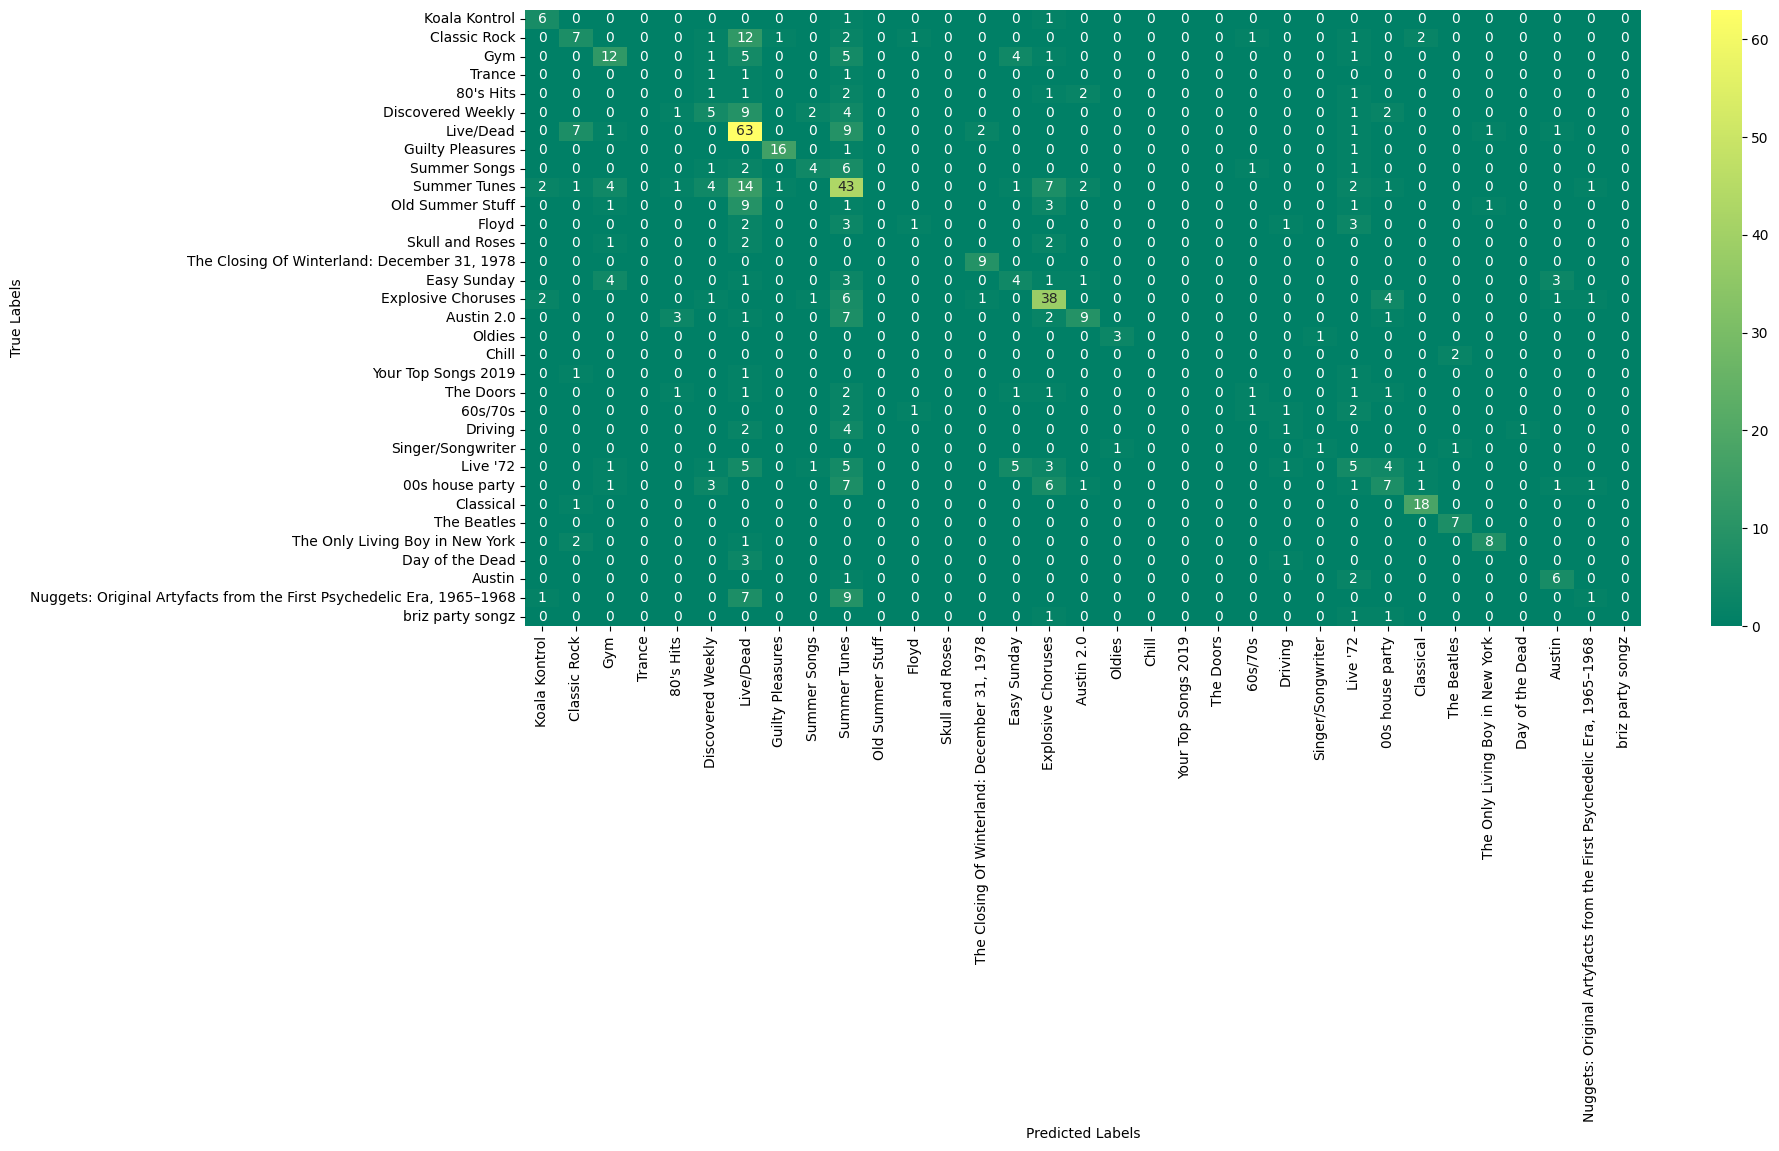

In [29]:
metrics.confusion_matrix(y_validation, y_pred)